# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
from pyspark.sql import SparkSession

import pyspark.sql.functions as F
from pyspark.sql.functions import avg, col, concat, desc, lit, min, max, split, udf, countDistinct, sum, count
from pyspark.sql.types import IntegerType
from pyspark.sql import Window

from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, Normalizer, StandardScaler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder


import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

In [2]:
# create a Spark session
spark = SparkSession.builder \
    .master("local") \
    .appName("Sparkify") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
sparkify_data = 'mini_sparkify_event_data.json'
df = spark.read.json(sparkify_data)

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [4]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [5]:
# Total sessions
df.count()

286500

In [6]:
# Count User
df.agg(countDistinct('userId')).show()

+-------------+
|count(userId)|
+-------------+
|          226|
+-------------+



In [7]:
df.where(df.userId == '').count()

8346

In [8]:
df.groupby('auth').agg(F.countDistinct('userId')).show()

+----------+-------------+
|      auth|count(userId)|
+----------+-------------+
|Logged Out|            1|
| Cancelled|           52|
|     Guest|            1|
| Logged In|          225|
+----------+-------------+



In [9]:
df.filter(df.auth == 'Cancelled').take(5)

[Row(artist=None, auth='Cancelled', firstName='Adriel', gender='M', itemInSession=104, lastName='Mendoza', length=None, level='paid', location='Kansas City, MO-KS', method='GET', page='Cancellation Confirmation', registration=1535623466000, sessionId=514, song=None, status=200, ts=1538943990000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.77.4 (KHTML, like Gecko) Version/7.0.5 Safari/537.77.4"', userId='18'),
 Row(artist=None, auth='Cancelled', firstName='Diego', gender='M', itemInSession=56, lastName='Mckee', length=None, level='paid', location='Phoenix-Mesa-Scottsdale, AZ', method='GET', page='Cancellation Confirmation', registration=1537167593000, sessionId=540, song=None, status=200, ts=1539033046000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='32'),
 Row(artist=None, auth='Cancelled', firstName='Mason', gender='M', itemInSession=10, la

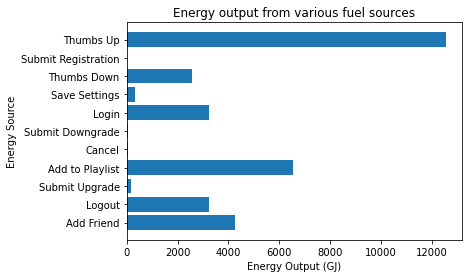

In [10]:
#Downgrade, Submit Downgrade
pages = df.groupby('page','method').count().sort('method')
pages_df = pages.toPandas()

pages_df_plt = pages_df.loc[(pages_df['method'] == 'PUT') & (pages_df['page'] != 'NextSong')]

activity = pages_df_plt['page']
count = pages_df_plt['count']

plt.barh(activity, count)
plt.ylabel("Energy Source")
plt.xlabel("Energy Output (GJ)")
plt.title("Energy output from various fuel sources")

plt.show()

In [11]:
pages.show()

+--------------------+------+-----+
|                page|method|count|
+--------------------+------+-----+
|               About|   GET|  924|
|                Help|   GET| 1726|
|           Downgrade|   GET| 2055|
|            Register|   GET|   18|
|             Upgrade|   GET|  499|
|               Error|   GET|  258|
|Cancellation Conf...|   GET|   52|
|            Settings|   GET| 1514|
|                Home|   GET|14457|
|         Roll Advert|   GET| 3933|
|          Add Friend|   PUT| 4277|
|              Logout|   PUT| 3226|
|              Cancel|   PUT|   52|
|      Submit Upgrade|   PUT|  159|
|     Add to Playlist|   PUT| 6526|
|    Submit Downgrade|   PUT|   63|
|         Thumbs Down|   PUT| 2546|
|               Login|   PUT| 3241|
|       Save Settings|   PUT|  310|
| Submit Registration|   PUT|    5|
+--------------------+------+-----+
only showing top 20 rows



In [12]:
df.filter(df.userId == '30').select(['artist','auth','method','location','registration','page','length']).show()

+--------------------+---------+------+---------------+-------------+---------------+---------+
|              artist|     auth|method|       location| registration|           page|   length|
+--------------------+---------+------+---------------+-------------+---------------+---------+
|      Martha Tilston|Logged In|   PUT|Bakersfield, CA|1538173362000|       NextSong|277.89016|
|        Adam Lambert|Logged In|   PUT|Bakersfield, CA|1538173362000|       NextSong| 282.8273|
|           Daft Punk|Logged In|   PUT|Bakersfield, CA|1538173362000|       NextSong|223.60771|
|        Starflyer 59|Logged In|   PUT|Bakersfield, CA|1538173362000|       NextSong|185.44281|
|                null|Logged In|   PUT|Bakersfield, CA|1538173362000|Add to Playlist|     null|
|            Frumpies|Logged In|   PUT|Bakersfield, CA|1538173362000|       NextSong|134.47791|
|Edward Sharpe & T...|Logged In|   PUT|Bakersfield, CA|1538173362000|       NextSong|223.58159|
|         Stan Mosley|Logged In|   PUT|B

In [13]:
# Downgrade Sample
df.filter(col('userId') == '131').groupby(['level','sessionId','page']\
                                         ).agg(min(col('ts')).alias('ts'),\
                                              sum(col('length')).alias('length')).sort(col('ts').desc()).show(50)

+-----+---------+----------------+-------------+------------------+
|level|sessionId|            page|           ts|            length|
+-----+---------+----------------+-------------+------------------+
| free|     2281|            Home|1543548083000|              null|
| free|     2155|      Add Friend|1543120417000|              null|
| free|     2155|     Thumbs Down|1543117205000|              null|
| free|     2155|            Home|1543114842000|              null|
| free|     2155|          Logout|1543114535000|              null|
| free|     2155|     Roll Advert|1543114106000|              null|
| free|     2155|       Thumbs Up|1543111791000|              null|
| free|     2155|           About|1543110822000|              null|
| free|     2155| Add to Playlist|1543109614000|              null|
| free|     2155|        NextSong|1543109551000|11182.815799999997|
| free|     2094|        NextSong|1542799890000|         563.35582|
| free|     2094|            Home|1542799886000|

In [14]:
# Convert ts to date
# from datetime import datetime
# get_day = udf(lambda x: datetime.fromtimestamp(x / 1000.0))

df_new = df.withColumn("date", F.to_date(F.from_unixtime(col('ts')/lit(1000))))
df_new.take(1)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', date=datetime.date(2018, 9, 30))]

In [15]:
#2018-10-01 to 2018-12-03 cutoff 2018-11-30
df_new.select('date').agg(min('date')).show()

+----------+
| min(date)|
+----------+
|2018-09-30|
+----------+



In [16]:
time = df_new.filter(col('date') < '2018-12-01' \
                    ).select(['date','sessionId','userId','level','song']\
                           ).groupby(['date','level']).agg(F.count(col('sessionId')), F.countDistinct(col('userId')),\
                                             F.count(col('song')))

In [17]:
df_time = time.toPandas()

In [18]:
df_time.head()

,date,level,count(sessionId),count(userId),count(song)
0,2018-11-25,paid,2654,28,2143
1,2018-10-27,free,455,12,342
2,2018-10-24,paid,4551,44,3747
3,2018-10-20,paid,4704,32,3830
4,2018-10-20,free,636,16,452


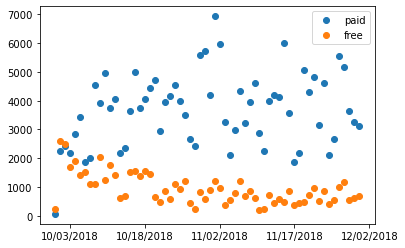

In [19]:
date = df_time['date']
count = df_time['count(sessionId)']

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=15))

# beautifying the labels
plt.plot_date(df_time['date'][df_time.level == "paid"], df_time['count(sessionId)'][df_time.level == "paid"], label = 'paid')
plt.plot_date(df_time['date'][df_time.level == "free"], df_time['count(sessionId)'][df_time.level == "free"], label = 'free')
plt.legend()
plt.show()

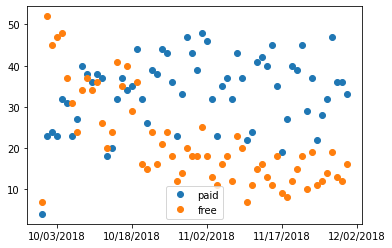

In [20]:
date = df_time['date']
count = df_time['count(userId)']

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=15))

# beautifying the labels
plt.plot_date(df_time['date'][df_time.level == "paid"], count[df_time.level == "paid"], label = 'paid')
plt.plot_date(df_time['date'][df_time.level == "free"], count[df_time.level == "free"], label = 'free')
plt.legend()
plt.show()

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [21]:
# User min date
df_new = df_new.withColumn('date_created', F.to_date(F.from_unixtime(col('registration')/lit(1000))))

In [22]:
df_new.select('date_created').agg(min('date_created')).show()

+-----------------+
|min(date_created)|
+-----------------+
|       2018-03-18|
+-----------------+



In [23]:
df_new = df_new.withColumn('user_age',F.datediff(col('date'),col('date_created')))

In [24]:
df_new.describe('user_age').show()

+-------+------------------+
|summary|          user_age|
+-------+------------------+
|  count|            278154|
|   mean| 64.75977695808797|
| stddev|42.019723870983626|
|    min|                -2|
|    max|               256|
+-------+------------------+



In [25]:
cancel = udf(lambda auth: 1 if auth == 'Cancelled' else 0, IntegerType())

In [26]:
cancelled = df_new.withColumn('cancel', cancel('auth'))

In [27]:
df_cancelled = cancelled.filter(col('cancel') == 1).select(['date','user_age','level']).toPandas()

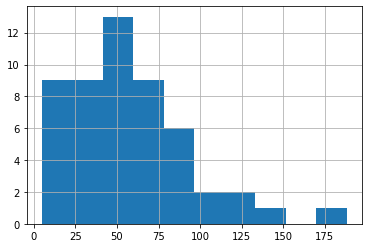

In [28]:
df_cancelled['user_age'].hist()

In [29]:
cancelled.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- date: date (nullable = true)
 |-- date_created: date (nullable = true)
 |-- user_age: integer (nullable = true)
 |-- cancel: integer (nullable = true)



In [30]:
inter = ['Thumbs Up', 'Thumbs Down', 'Add to Playlist', 'Add Friend']
get_interactions = udf(lambda x: 1 if x in inter else 0, IntegerType())
thumbs_down = udf(lambda x: 1 if x == 'Thumbs Up' else 0, IntegerType())

songs = udf(lambda x: 1 if x == 'NextSong' else 0, IntegerType())

In [31]:
interactions = cancelled.withColumn('interactions', get_interactions('page'))
interactions = interactions.withColumn('thumbs_down', thumbs_down('page'))

In [32]:
interactions = interactions.withColumn('songs', songs('page'))

In [33]:
paid_hist = udf(lambda x: 1 if x == 'paid' else 0, IntegerType())
interactions = interactions.withColumn('paid_hist', paid_hist('level'))

In [34]:
downgrade = udf(lambda x: 1 if x == 'Submit Downgrade' else 0, IntegerType())
interactions = interactions.withColumn('downgraded', downgrade('page'))

In [35]:
interactions.take(1)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', date=datetime.date(2018, 9, 30), date_created=datetime.date(2018, 9, 28), user_age=2, cancel=0, interactions=0, thumbs_down=0, songs=1, paid_hist=1, downgraded=0)]

In [36]:
dims = interactions.groupby('userId','gender','date_created').agg(\
                                                          max('user_age').alias('user_age'),\
                                                          max('paid_hist').alias('paid_user'),\
                                                          max('downgraded').alias('downgraded'),\
                                                          max('cancel').alias('canceled'))

In [37]:
dims.take(1)

[Row(userId='100022', gender='F', date_created=datetime.date(2018, 9, 25), user_age=48, paid_user=0, downgraded=0, canceled=1)]

In [38]:
measures = interactions.groupby('userId','sessionId').agg(\
                                                          min('date').alias('start_date'),\
                                                          max('date').alias('end_date'),\
                                                          sum('interactions').alias('interactions'),\
                                                          sum('thumbs_down').alias('thumbs_down'),\
                                                          sum('songs').alias('songs'),\
                                                          sum('length').alias('length'),\
                                                         F.countDistinct('artist').alias('c_artist'))

In [39]:
measures.take(1)

[Row(userId='101', sessionId=635, start_date=datetime.date(2018, 10, 9), end_date=datetime.date(2018, 10, 11), interactions=72, thumbs_down=35, songs=708, length=176615.41127, c_artist=587)]

In [40]:
measures_lag = measures.withColumn('prev_end_date',
                        F.lag(col('end_date')).over(Window.partitionBy('userID').orderBy('start_date')))

In [41]:
measures_lag = measures_lag.withColumn('session_gap',\
                                      F.datediff(col('start_date'),col('prev_end_date')))

In [42]:
measures_agg = measures_lag.groupby('userId').agg(\
                                                 F.count('sessionId').alias('total_session'),\
                                                 avg('interactions').alias('interactions'),\
                                                 avg('thumbs_down').alias('thumbs_down'),\
                                                 avg('songs').alias('songs'),\
                                                 avg('length').alias('length'),\
                                                 avg('c_artist').alias('artists'),\
                                                 avg('session_gap').alias('session_gap'))

In [43]:
measures_agg.take(1)

[Row(userId='100010', total_session=7, interactions=4.714285714285714, thumbs_down=2.4285714285714284, songs=39.285714285714285, length=9562.985335714286, artists=38.57142857142857, session_gap=7.166666666666667)]

In [44]:
measures_agg.count()
dims.count()

226

In [45]:
output = dims.join(measures_agg, on = 'userId')

In [46]:
female = udf(lambda x: 1 if x == 'F' else 0, IntegerType())
output = output.withColumn('female', female('gender'))

In [47]:
output.printSchema()

root
 |-- userId: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- date_created: date (nullable = true)
 |-- user_age: integer (nullable = true)
 |-- paid_user: integer (nullable = true)
 |-- downgraded: integer (nullable = true)
 |-- canceled: integer (nullable = true)
 |-- total_session: long (nullable = false)
 |-- interactions: double (nullable = true)
 |-- thumbs_down: double (nullable = true)
 |-- songs: double (nullable = true)
 |-- length: double (nullable = true)
 |-- artists: double (nullable = true)
 |-- session_gap: double (nullable = true)
 |-- female: integer (nullable = true)



# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [49]:
assembler = VectorAssembler(inputCols=['female','user_age','paid_user',\
                                       'downgraded','total_session','interactions',\
                                      'thumbs_down','songs','length','artists','session_gap'],\
                            outputCol='NumFeatures',handleInvalid = 'skip')
data = assembler.transform(output)

In [80]:
data = data.withColumnRenamed('canceled','label')

In [50]:
# for i in ['female','user_age','paid_user',\
#                                        'downgraded','total_session','interactions',\
#                                       'thumbs_down','songs','length','artists','session_gap']:
#     print(output.where(col(i).isNull()).count())

In [51]:
# output.where(col('songs').isNull()).collect()

In [52]:
# data2 = data.select(col('canceled').alias('label'), col('NumFeatures').alias('features'))

In [54]:
# data2.take(1)

In [55]:
# lr = LogisticRegression(maxIter=10, regParam=0.0)
# lrModel_q1 = lr.fit(data2)

In [56]:
# lrModel_q1.coefficientMatrix

In [57]:
# lrModel_q1.summary.accuracy

In [58]:
# scaler_q1 = Normalizer(inputCol="NumFeatures", outputCol="FeatNormalizer")
# data_norm = scaler_q1.transform(data)

In [59]:
# scaler_q2 = StandardScaler(inputCol="NumFeatures", outputCol="FeatStandard", withMean=True, withStd=True)
# stdmodel = scaler_q2.fit(data)
# data_std = stdmodel.transform(data)

In [60]:
# df.take(1)

In [61]:
# data3 = data_std.select(col('canceled').alias('label'), col('FeatStandard').alias('features'))
# lr = LogisticRegression(maxIter=10, regParam=0.0)

# lrModel_q1 = lr.fit(data3)

In [62]:
# lrModel_q1.summary.accuracy

In [63]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [84]:
test, validation = data.randomSplit([0.8, 0.2], seed=42)

In [72]:
standardscaler = StandardScaler(inputCol="NumFeatures", outputCol="features", withMean=True, withStd=True)
lr = LogisticRegression(maxIter=10, regParam=0.0)

In [73]:
pipeline = Pipeline(stages=[standardscaler, lr])

paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam,[0.0, 0.1])\
    .addGrid(standardscaler.withMean,[True, False])\
    .build()

In [74]:
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)

In [79]:
test.take(1)

[Row(userId='100010', gender='F', date_created=datetime.date(2018, 9, 26), user_age=56, paid_user=0, downgraded=0, canceled=0, total_session=7, interactions=4.714285714285714, thumbs_down=2.4285714285714284, songs=39.285714285714285, length=9562.985335714286, artists=38.57142857142857, session_gap=7.166666666666667, female=1, NumFeatures=DenseVector([1.0, 56.0, 0.0, 0.0, 7.0, 4.7143, 2.4286, 39.2857, 9562.9853, 38.5714, 7.1667]))]

In [81]:
paramGridcvModel_q1 = crossval.fit(test)

IllegalArgumentException: label does not exist. Available: userId, gender, date_created, user_age, paid_user, downgraded, canceled, total_session, interactions, thumbs_down, songs, length, artists, session_gap, female, NumFeatures, CrossValidator_eaf32ee7daf8_rand, features

In [ ]:
cvModel_q1.avgMetrics
results = cvModel_q1.transform(validation)

In [ ]:
print(results.filter(results.label == results.prediction).count())
print(results.count())

In [70]:
# define churn
# Downgrade: Submit Downgrade
# Cancel: 